In [1]:
%load_ext autoreload
%autoreload 


In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid

from ghosts import plotter
from ghosts import simulator
from ghosts import tweak_optics
from ghosts import beam
from ghosts import geom


from ghosts.analysis import compute_ghost_separations, reduce_ghosts
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1
from ghosts.geom_config import GEOM_CONFIG_0


In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 36000 pixels per mm^2


In [4]:
# CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

In [5]:
# test list of optics
assert tweak_optics.get_list_of_optics(telescope)==['L1', 'L2', 'Filter', 'L3', 'Detector'], 'Not a CCOB optical setup'

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope)


0.02

In [6]:
# Run simulation with standard beam config
traceFull, rForward, rReverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)


In [7]:
# Analyze
spots_data, _spots = reduce_ghosts(rForward)
data_frame = make_data_frame(spots_data, BEAM_CONFIG_1['beam_id'], GEOM_CONFIG_0['geom_id'])


In [8]:
data_frame.head()

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,surface,pixel_signal
0,1,0,0,"(L1_exit, L1_entrance)",0.044609,0.000272,-1.074868e-05,0.000272,0.001085,0.001111,0.001098,0.000013,3.789394,523.039699
1,1,0,1,"(L2_exit, L1_entrance)",0.142107,0.000866,-3.424081e-05,0.000866,0.003453,0.003540,0.003497,0.000043,38.407599,47.598308
2,1,0,2,"(L2_exit, L1_exit)",0.218204,0.001337,-5.257690e-05,0.001337,0.005331,0.005435,0.005383,0.000052,91.037326,20.909181
3,1,0,3,"(L2_entrance, L1_entrance)",0.003180,0.000018,-7.661879e-07,0.000018,0.000071,0.000079,0.000075,0.000004,0.017706,107507.460952
4,1,0,4,"(L2_entrance, L1_exit)",0.055201,0.000337,-1.330086e-05,0.000337,0.001343,0.001375,0.001359,0.000016,5.801262,341.650352


In [9]:
# Test building several beams
x_scan = [0., 0.05, 0.1, 0.15, 0.2]
t_scan = [0, 5, 10, 15]

In [10]:
beam_scan_x = beam.build_translation_set(BEAM_CONFIG_0, 'x', x_scan, base_id=10000)
beam_scan_t = beam.build_rotation_set(BEAM_CONFIG_1, 'theta', t_scan, base_id=20000)

In [11]:
beam_scan_x_panda = beam.concat_dicts(beam_scan_x)
beam_scan_x_panda.head()

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,theta,phi
10000,10000,5.000000e-07,1000,0.00125,0.00,0,0,0.0,0.0
10001,10001,5.000000e-07,1000,0.00125,0.05,0,0,0.0,0.0
10002,10002,5.000000e-07,1000,0.00125,0.10,0,0,0.0,0.0
10003,10003,5.000000e-07,1000,0.00125,0.15,0,0,0.0,0.0
10004,10004,5.000000e-07,1000,0.00125,0.20,0,0,0.0,0.0


In [12]:
beam_scan_t_panda = beam.concat_dicts(beam_scan_t)
beam_scan_t_panda.head()

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,theta,phi
20000,20000,5.000000e-07,1000,0.00125,0.1,0,0,0,0.0
20001,20001,5.000000e-07,1000,0.00125,0.1,0,0,5,0.0
20002,20002,5.000000e-07,1000,0.00125,0.1,0,0,10,0.0
20003,20003,5.000000e-07,1000,0.00125,0.1,0,0,15,0.0


In [29]:
# test make fast beams on the data frame for all beam configurations
beam_scan_t_panda['n_photons']=100
beam_scan_t_panda.head()

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,theta,phi
20000,20000,5.000000e-07,100,0.00125,0.1,0,0,0,0.0
20001,20001,5.000000e-07,100,0.00125,0.1,0,0,5,0.0
20002,20002,5.000000e-07,100,0.00125,0.1,0,0,10,0.0
20003,20003,5.000000e-07,100,0.00125,0.1,0,0,15,0.0


In [30]:
beams = beam.concat_frames([beam_scan_x_panda, beam_scan_t_panda])
beams

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,theta,phi
10000,10000,5.000000e-07,1000,0.00125,0.00,0,0,0.0,0.0
10001,10001,5.000000e-07,1000,0.00125,0.05,0,0,0.0,0.0
10002,10002,5.000000e-07,1000,0.00125,0.10,0,0,0.0,0.0
10003,10003,5.000000e-07,1000,0.00125,0.15,0,0,0.0,0.0
10004,10004,5.000000e-07,1000,0.00125,0.20,0,0,0.0,0.0
20000,20000,5.000000e-07,100,0.00125,0.10,0,0,0.0,0.0
20001,20001,5.000000e-07,100,0.00125,0.10,0,0,5.0,0.0
20002,20002,5.000000e-07,100,0.00125,0.10,0,0,10.0,0.0
20003,20003,5.000000e-07,100,0.00125,0.10,0,0,15.0,0.0


In [31]:
# take one beam
my_beam_config = beam.to_dict(beams[beams['beam_id']==20001])
traceFull_2, rForward_2, rReverse_2, rays_2 = simulator.run_simulation(telescope, beam_config=my_beam_config)


Direct path is number 28
  central impact point is (0.099449, -0.000118)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 73.4553


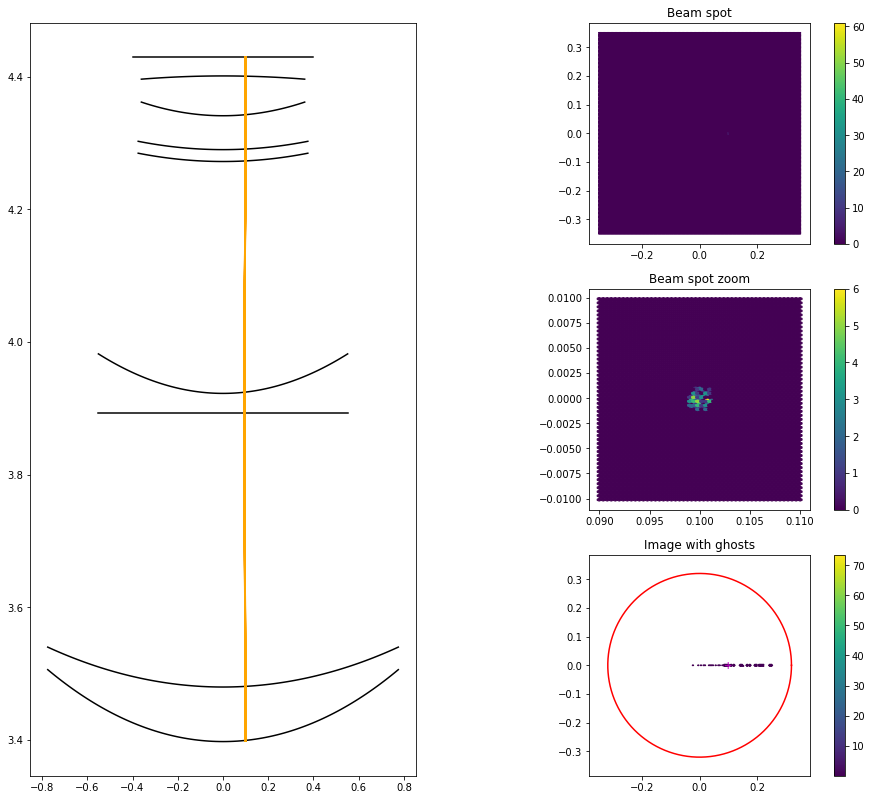

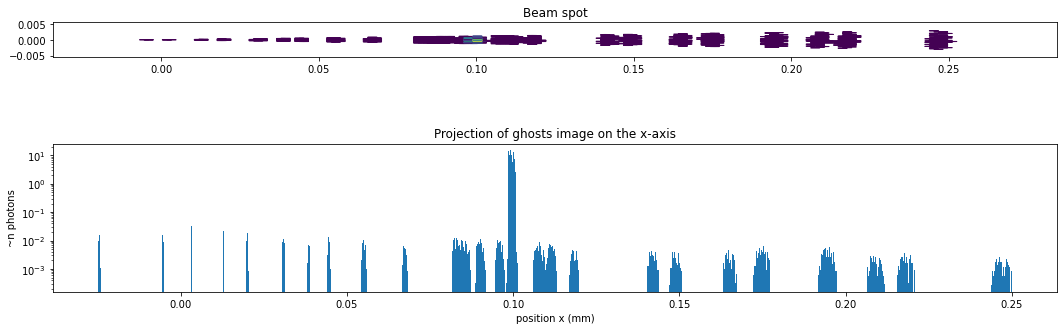

0

In [32]:
# take sim
simulation_2 = [traceFull_2, rForward_2, rReverse_2, rays_2]
# Check setup
plotter.plot_setup(telescope, simulation_2)
# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward_2)

In [33]:
# Analyze
spots_data_2, _spots_2 = reduce_ghosts(rForward_2)
data_frame_2 = make_data_frame(spots_data_2, my_beam_config['beam_id'], GEOM_CONFIG_0['geom_id'])
data_frame_2.head()

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,surface,pixel_signal
0,20001,0,0,"(L1_exit, L1_entrance)",0.044577,0.000270,-0.000053,0.000270,0.001044,0.001058,0.001051,0.000007,3.470402,571.116278
1,20001,0,1,"(L2_exit, L1_entrance)",0.142005,0.000858,-0.000168,0.000858,0.003321,0.003371,0.003346,0.000025,35.174245,51.973730
2,20001,0,2,"(L2_exit, L1_exit)",0.218048,0.001325,-0.000258,0.001325,0.005127,0.005177,0.005152,0.000025,83.375405,22.830665
3,20001,0,3,"(L2_entrance, L1_entrance)",0.003178,0.000018,-0.000004,0.000018,0.000068,0.000075,0.000072,0.000004,0.016209,117436.506015
4,20001,0,4,"(L2_entrance, L1_exit)",0.055162,0.000334,-0.000065,0.000334,0.001291,0.001310,0.001300,0.000009,5.312906,373.054436


(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

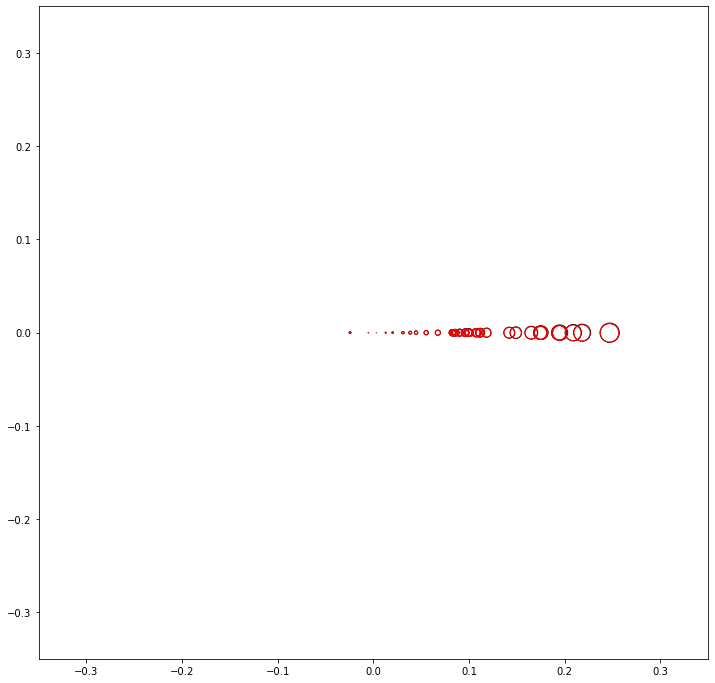

In [34]:
# show beam spots
plotter.plot_spots([data_frame, data_frame_2], spot_size_scaling=10, range_x=(-0.35, 0.35), range_y=(-0.35, 0.35))